# COMP4432 Individual Project

## Sentiment Analysis and Text Classification on IMDB Movie Reviews Dataset

JAHJA Darwin // 16094501d

---
## Intro

Sentiment analysis is a challenging subject in machine learning. People express their emotions in language that is often obscured by sarcasm, ambiguity, and plays on words, all of which could be very misleading for both humans and computers. In this project, we are going to perform some sentimental analysis on the IMDB movie reviews to see how we can train a model that predicts whether a review is positive or negative.

In these 2 notebooks, we are going to combining pre-trained word2vec embeddings with Bidirectional Long short-term memory (BiLSTM) to build out our machine learning modal. The source code and report are based on two Jupyter Notebooks -- one for data preprocessing and Word2Vec Modelling, one for modelling -- for better understanding.

To give a short summary, in the beginning without using the word2vec embeddings (only tokenize), I reach ~70% accuracy with the testing dataset. With pre-trained word2vec embeddings and some parameter tunings, the final accurary have reached 78%. The result could probably still be improved with more training dataset and parameter tuning.

## Importing packages and dataset

First, we need to import package and dataset to start.

As the data is not properly organized in a formatted way, I have processes all the datasets into `.csv` file.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd
import re
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# File system tool
import os
from pathlib import Path

In [2]:
# # Input data files are available in the "input/" directory
# # This process takes a lot of IO process and I've read and write all data into '.csv' file
# def load_data_from(directory, sublist):
#     results, texts = [], []
#     for label_type in sublist:
#         dir_name = os.path.join(directory, label_type)
#         for fname in os.listdir(dir_name):
#             if fname[-4:] == '.txt':
#                 f = open(os.path.join(dir_name, fname), encoding='utf8')
#                 texts.append(f.read())
#                 f.close()
#                 if label_type == 'neg':
#                     results.append(0)
#                 elif label_type == 'pos':
#                     results.append(1)
#     return results, texts

# # Note: change '\\' to '/' in unix based system
# imdb_dir = 'input\\imdb-movie-reviews-dataset\\aclImdb'
# train_dir = os.path.join(imdb_dir, 'train')
# test_dir = os.path.join(imdb_dir, 'test')

# sentiments, reviews = load_data_from(train_dir, ['pos', 'neg'])
# test_sentiments, test_reviews = load_data_from(test_dir, ['pos', 'neg'])
# _, unsup_reviews = load_data_from(train_dir, ['unsup'])

# train_data = pd.DataFrame({'review': reviews, 'sentiment': sentiments})
# test_data = pd.DataFrame({'review': test_reviews, 'sentiment': test_sentiments})
# unsup_data = pd.DataFrame({'review': unsup_reviews})

# train_data.to_csv('resources/train.csv', index=False)
# test_data.to_csv('resources/test.csv', index=False)
# unsup_data.to_csv('resources/unsup.csv', index=False)

In [3]:
# Read files from csv
train_data = pd.read_csv('resources/train.csv')
test_data = pd.read_csv('resources/test.csv')
unsup_data = pd.read_csv('resources/unsup.csv')

datasets = [train_data, test_data, unsup_data]
titles = ['Train data', 'Test data', 'Unsup train data']

for dataset, title in zip(datasets,titles):
    print(f'\n{title}')
    dataset.info()


Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
review       25000 non-null object
sentiment    25000 non-null int64
dtypes: int64(1), object(1)
memory usage: 390.8+ KB

Test data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
review       25000 non-null object
sentiment    25000 non-null int64
dtypes: int64(1), object(1)
memory usage: 390.8+ KB

Unsup train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
review    50000 non-null object
dtypes: object(1)
memory usage: 390.8+ KB


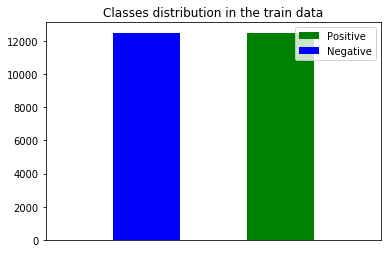

In [4]:
# Show class distribution
plt.hist(train_data[train_data.sentiment == 1].sentiment,
         bins=2, color='green', label='Positive')
plt.hist(train_data[train_data.sentiment == 0].sentiment,
         bins=2, color='blue', label='Negative')
plt.title('Classes distribution in the train data')
plt.xticks([])
plt.xlim(-0.5, 2)
plt.legend()
plt.show()

In [5]:
# Prepare total number of review
all_reviews = np.array([], dtype=str)
for dataset in datasets:
    all_reviews = np.concatenate((all_reviews, dataset.review), axis=0)
print('Total number of reviews:', len(all_reviews))

Total number of reviews: 100000


## Data Preprocessing

Let's see how an original review looks like:

In [6]:
# Limiting some output
print(all_reviews[0][:500] + '...')

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a s...


There are HTML tags (e.g. `<br />`), punctuations, abbreviations - all common issues when processing text from the Internet.

Apart from those issues, we need to deal with the common words (a.k.a stop words) that don't carry much meaning (e.g. in, on, to, etc.). Also, we also need to perform lemmatization to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. (e.g. car, cars, car's, cars' => car).

Therefore, we need to clean and tidy them up using some useful and handy packages.

- **BeautifulSoup:** For cleaning up HTML Markup
- **Natural Language Toolkit (NLTK):** Tokenize words, Remove stop words and perform Lemmatize

Below we define some functions to perform the above operations:

In [7]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def clean_review(raw_review: str) -> str:
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review, "lxml").get_text()
    # 2. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    # 3. Convert to lower case
    lowercase_letters = letters_only.lower()
    return lowercase_letters

def lemmatize(tokens: list) -> list:
    # Do Lemmatize
    lemmatized_tokens = list(map(lemmatizer.lemmatize, tokens))
    further_lemmatized_tokens = list(map(lambda x: lemmatizer.lemmatize(x, "v"), lemmatized_tokens))
    return further_lemmatized_tokens

def preprocess(review: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    # 1. Clean text
    review = clean_review(review)
    # 2. Split into individual words
    tokens = word_tokenize(review)
    # 3. Remove stop words
    meaningful = list(filter(lambda x: not x in stop_words, tokens))
    # 4. Lemmatize
    lemmas = lemmatize(meaningful)
    # 5. Join the words back into one string separated by space,
    # and return the result.
    return lemmas

And let's preprocessing the dataset and see how are the processed review look like.

In [8]:
# Run preprocessing to the training dataset
counter = 0
clean_all_reviews = np.array(list(map(lambda x: preprocess(x, all_reviews.size), all_reviews)))

In [9]:
# Compare how a review has been processed
print(all_reviews[0])
print(clean_all_reviews[0])

Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I'm here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn't!
['bromwell', 'high', 'cartoon', 'comedy', 'run', 'time', 'program', 'school', 'life', 'teacher', 'year', 'teach', 'profession', 'lead', 'believe', 'bromwell', 'high', 'satire', 'much', 'closer'

Let's also see how the word per review distribution for the training data.

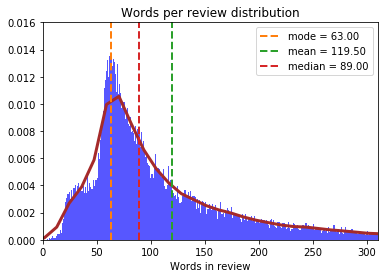

In [10]:
X_train_data = clean_all_reviews[:train_data.shape[0]]
Y_train_data = train_data.sentiment.values

train_data['review_lenght'] = np.array(list(map(len, X_train_data)))
median = train_data['review_lenght'].median()
mean = train_data['review_lenght'].mean()
mode = train_data['review_lenght'].mode()[0]

fig, ax = plt.subplots()
sb.distplot(train_data['review_lenght'], bins=train_data['review_lenght'].max(),
            hist_kws={"alpha": 0.66, "color": "blue"}, ax=ax,
            kde_kws={"color": "brown", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(train_data['review_lenght'], 95))
ax.set_xlabel('Words in review')
ymax = 0.016
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=2)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=2)
ax.plot([median, median], [0, ymax], '--', label=f'median = {median:.2f}', linewidth=2)
ax.set_title('Words per review distribution')
plt.legend()
plt.show()

## Distributed Word Vectors

With the processed `clean_all_reviews` data, we can now proceed to construct our distributed word vectors model using the Word2vec algorithm.

Word2vec (Google, 2013) is a neural network implementation that learns distributed representations for words. It does not need labels in order to create meaningful representations. This is useful, since most data in the real world is unlabeled. If the network is given enough training data (tens of billions of words), it produces word vectors with intriguing characteristics. Words with similar meanings appear in clusters, and clusters are spaced such that some word relationships, such as analogies, can be reproduced using vector math. The famous example is that, with highly trained word vectors, "king - man + woman = queen."

Let's first use gensim's phrases to find bigrams or trigrams from our data:

In [11]:
%%time
bigrams = Phrases(sentences=clean_all_reviews)

Wall time: 21.9 s


In [12]:
%%time
trigrams = Phrases(sentences=bigrams[clean_all_reviews])

Wall time: 1min 10s


In [13]:
# Which will work like this (as an example)
print(bigrams['train station near new york'.split()])

['train_station', 'near', 'new_york']


And let's start to train our Word2Vec model. (This would take quite a long time, so we run it as an individual code block)

In [14]:
%%time
embedding_vector_size = 256
trigrams_model = Word2Vec(
    sentences=trigrams[bigrams[clean_all_reviews]],
    size=embedding_vector_size,
    min_count=3, window=5, workers=4)

Wall time: 10min 1s


In [15]:
print("Vocabulary size:", len(trigrams_model.wv.vocab))

Vocabulary size: 92287


Finally done! And now we can use our word2vec model to build a word embedding. Also we can use this model to define most similar words, calculate diffence between the words, etc.

In [16]:
# Find similar words
trigrams_model.wv.most_similar('planet')

[('earth', 0.8660895228385925),
 ('galaxy', 0.7575183510780334),
 ('specie', 0.756401777267456),
 ('universe', 0.7411483526229858),
 ('civilization', 0.7340728044509888),
 ('asteroid', 0.7148683667182922),
 ('radiation', 0.7132657766342163),
 ('spaceship', 0.705843448638916),
 ('island', 0.7051829695701599),
 ('colony', 0.7034358978271484)]

In [17]:
# Find the difference
trigrams_model.wv.doesnt_match(['planet', 'earth', 'space', 'cat'])

'cat'

Let's output the current model to the resources directory first.

In [18]:
# Dump the model as a pickles
pickle.dump(trigrams_model, open('resources/trigrams_model.pickle', 'wb'))

The next thing we need to do is to convert sentences to sentences with ngrams for vetorizing our sentences. And with the vetorized sentences, we can transform them into sequences to build the model. The vectorizing step will be done in part 2 since that process would take quite a bit of time.

In [19]:
%%time
# Load test data
test_start = train_data.shape[0]
test_end = test_start + test_data.shape[0]
X_test_data = clean_all_reviews[test_start:test_end]
Y_test_data = test_data.sentiment.values

# Convert sentences to sentences-with-n-grams
print('Convert sentences to sentences-with-n-grams...', end='\r')
X_train = trigrams[bigrams[X_train_data]]
print('Convert sentences to sentences-with-n-grams... (done)')

print('Convert sentences to sentences-with-n-grams...', end='\r')
X_test = trigrams[bigrams[X_test_data]]
print('Convert sentences to sentences-with-n-grams... (done)')

# Dump the formatted dataset also as pickles
pickle.dump([X_train, Y_train_data], open('resources/trainset.pickle', 'wb'))
pickle.dump([X_test, Y_test_data], open('resources/testset.pickle', 'wb'))

Convert sentences to sentences-with-n-grams... (done)
Convert sentences to sentences-with-n-grams... (done)
Wall time: 16.5 s


---
**End of Part 1**